# Notebook : modélisation de la croissance d'un réseau d'espionnage

### Projet compagnon Maxime Nicaise

On s'intéresse au problème suivant :
\begin{array}{ll}
\frac{\partial u}{\partial t} = D \Delta u + \alpha u (1 - u) - \beta u v \\
u(0, \cdot) = u_0
\end{array}
Avec $D = 0.15$, $\alpha = \frac{1}{2}$, et $\beta = \frac{1}{2}$, et $v$ une fonction de classe $C^{\infty}$ à valeurs dans $[0,1]$ définie ainsi : 
$$v =\frac{1}{4}(3g_{(0.85,0.75),0.2}+2g_{(0.1,0.25),0.35}+g_{(0.85,0.8),0.02}+g_{(0.9,0.62),0.02}+2g_{(0.4,0.8),0.02}+g_{(0.08,0.25),0.025}).$$
Où $g_{\mu,\sigma} : (x,y) \mapsto e^{-\frac{(x-\mu_1)^2+(y-\mu_2)^2}{2\sigma^2}}.$
$\\$

On essaie de résoudre l'équation pour $(x,y) \in \Omega = ]0,1[^2$, et $ t \geq 0$. On montre dans l'étude théorique qu'il existe une unique solution à ce problème, $u \in C^1(\mathbb{R}_{+},C^0(\Omega)) \cap C^0(\mathbb{R}_{+},H^1_0(\Omega))$.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import math

#définition des paramètres du problème
alpha = 1/2
beta = 1/2
D = 0.15

#on utilise cette fonction pour pouvoir définir v plus facilement
def gaussienne(x,y,mu,sigma):
    x0, y0 = mu
    gauss = np.exp(-((x - x0)**2 / (2 * sigma**2) + (y - y0)**2 / (2 * sigma**2)))
    return gauss

#On divise la somme des gaussiennes par 4 pour que v reste à valeurs entre 0 et 1
def v(x, y):
    res =  3*gaussienne(x,y,(0.85,0.75),0.2)+2*gaussienne(x,y,(0.1,0.25),0.35)+gaussienne(x,y,(0.85,0.8),0.02)+gaussienne(x,y,(0.9,0.62),0.02)+2*gaussienne(x,y,(0.4,0.8),0.02)+gaussienne(x,y,(0.08,0.25),0.025)
    return res/4

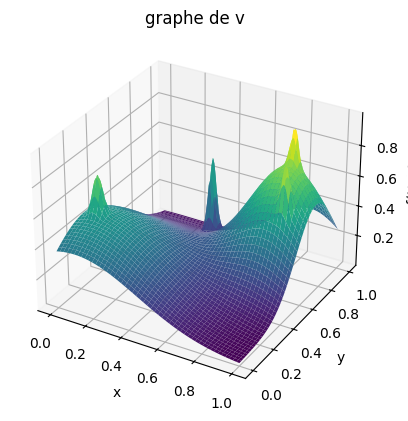

In [53]:
#Cette cellule sert à tracer le graphe de v.
x = np.linspace(0, 1, 200)
y = np.linspace(0, 1, 200)
X, Y = np.meshgrid(x, y)
Z = v(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(X, Y)')
ax.set_title('graphe de v')
plt.show()

On définit maintenant la condition initiale $u_0$, de classe $C^{\infty}$ et à support compact dans $\Omega$, pour vérifier les hypothèses de l'étude théorique.

In [71]:
#Cette fonction est la brique de base qui va nous permettre de construire u_0. il s'agit d'une fonction de classe C infinie, positive,
#dont le support est la boule unité de R^2. En composant cette fonction avec des dilatations et des translations, on obtient des 
#fonctions C infinies dont on contrôle les supports.

def ftest(x, y):
    r = np.sqrt(x**2 + y**2)
    result = np.exp(-1/(1-r**2))
    mask = (r >= 1)
    result[mask] = 0
    return result

#On construit u_0 en sommant des fonctions C infinies dont les supports sont inclus dans Omega. On prend garde à ne pas dépasser 1
def u_0(x,y):
    return 1.5*ftest(5*(x-0.8),5*(y-0.8))+0.75*ftest(5*(x-0.3),5*(y-0.2))+ftest(2*(x-1/2),2*(y-1/2))+0.5*ftest(5*(x-0.4),5*(y-0.8))

C:\Users\mnica\AppData\Local\Temp\ipykernel_7080\818015218.py:7: RuntimeWarning: overflow encountered in exp
  result = np.exp(-1/(1-r**2))


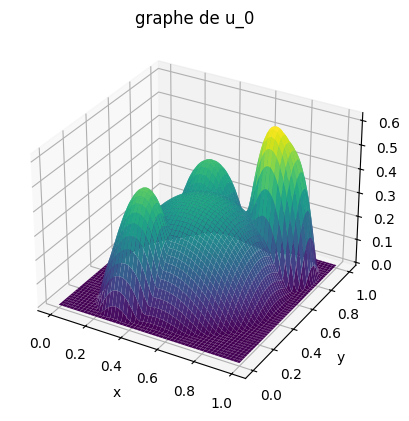

In [72]:
#Cette cellule sert à tracer le graphe de u_0
Z2 = u_0(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z2, cmap='viridis')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('graphe de u_0')
plt.show()

Maintenant que tous les paramètres sont définis, on va pouvoir implémenter une méthode de résolution de cette équation. La non linéarité de ce problème rend l'utilisation de méthodes aux différences implicites difficiles. C'est pourquoi on utilisera le schéma centré spatial aux différences explicites suivant :

\begin{cases}
    \frac{u^{k+1}_{i,j} - u^{k}_{i,j}}{\Delta t} &= D\frac{u^{k}_{i+1,j} - 2u^{k}_{i,j} + u^{k}_{i-1,j} + u^{k}_{i,j+1} - 2u^{k}_{i,j} + u^{k}_{i,j-1}}{\Delta x^2} + \alpha u^{k}_{i,j}(1 - u^{k}_{i,j}) - \beta u^{k}_{i,j} v(x_i,x_j) \\
    u^0_{i,j} &= u_0(x_i,x_j)
\end{cases}

En prenant la convention que $u^{k}_{i-1,j} = 0 $ si $i = 1$, vu $u(t) \in H^1_0(\Omega)$.
On veillera à préserver l'inégalité $\frac{D\Delta t}{\Delta x^2} \leq \frac{1}{2}$, qui assurera peut-être la convergence du schéma.



On va maintenant implémenter la fonction qui propose une solution approchée en utilisant le schéma décrit plus haut. Pour s'assurer que l'inégalité $\frac{D\Delta t}{\Delta x^2} \leq \frac{1}{2}$ est préservée, on donnera seulement le nombre de points en temps $N_t$ en argument, et on en déduira dans la fonction le nombre de points $N_x$ de points qu'on prendra par segment en espace.

Si on prend $N_t$ points en temps, alors on a $\Delta t = \frac{1}{N_t -1}$. On veut avoir $\frac{D\Delta t}{\Delta x^2} \leq \frac{1}{2}$, donc il faut $\Delta x \geq \sqrt{2D\Delta t}$. Rappelons que puisqu'on discrétise $]0,1[^2$, on a $\Delta x = \frac{1}{N_x+1}$, donc on veut prendre $N_x$ qui vérifie $N_x \leq \frac{1}{\sqrt{2D\Delta t}}-1$. On prend par exemple $N_x = \lfloor \frac{1}{\sqrt{2D\Delta t}}-1 \rfloor$.

In [75]:
#On redéfinit ftest ici car la version "vectorisée" qu'on a utilisée pour dessiner le graphe de u_0 n'est pas adaptée ici

def ftest(x, y):
    if x**2 + y**2 < 1:
        return math.exp(-1/(1 - (x**2 + y**2)))
    else:
        return 0

In [63]:
#La fonction prend T en argument pour qu'on puisse choisir sur quel intervalle de temps on résout l'équation.

def differences_explicites(T, Nt, D, alpha, v, beta, u_0):
    dt = T / (Nt - 1)
    Nx = math.floor((1/np.sqrt(2*D*dt))-1)
    dx = 1/(Nx+1)
    x = np.linspace(dx, 1-dx, Nx)
    y = np.linspace(dx, 1-dx, Nx)
    u = np.zeros((Nt, Nx, Nx))
    u[0] = [[u_0(i,j) for j in y ] for i in x]
    for k in range(Nt - 1):
        d2u = np.zeros_like(u[k])
        d2u = np.zeros_like(u[k])
        for i in range(1, Nx-1):
            for j in range(1, Nx-1):
                d2u[i, j] = (u[k, i+1, j] - 2*u[k, i, j] + u[k, i-1, j]) / dx**2
                d2u[i, j] = (u[k, i, j+1] - 2*u[k, i, j] + u[k, i, j-1]) / dx**2
                u[k+1, :, :] = u[k, :, :] + dt * (
            D * (d2u + d2u)
            + alpha * u[k, :, :] * (1 - u[k, :, :])
            - beta * u[k, :, :] * v(x,y)
        )
    
    return u




On devrait maintenant pouvoir utiliser cette fonction pour calculer la solution de notre problème. On fait des tests en faisant varier $T$ et $N_t$ :

In [105]:
#On constate déjà que si les valeurs de Nt dépassent celles qu'on a rentrées, l'ordinateur ne sait pas faire le calcul. C'est un gros problème
#car ces valeurs sont très faibles et ne permettent pas a priori d'avoir une approximation précise de la solution

u1 = differences_explicites(10, 108, D, alpha, v, beta, u_0)
u2 = differences_explicites(5, 54, D, alpha, v, beta, u_0)
u3 =  differences_explicites(1, 10, D, alpha, v, beta, u_0)
u4 = differences_explicites(1000, 10800, D, alpha, v, beta, u_0)


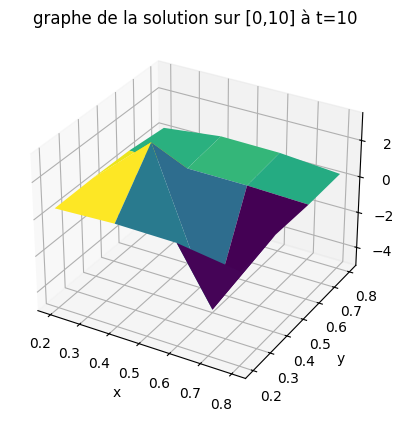

In [111]:
#Cette cellule sert à tracer le graphe de la solution sur [0,10] à t =10

u_f1 = u1[107]
Nx = Ny = u_f1.shape[0]
dx = 1/(Nx+1)
X = np.linspace(dx, 1-dx, Nx)
Y = np.linspace(dx, 1-dx, Nx)
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, u_f1, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u_f')
ax.set_title('graphe de la solution sur [0,10] à t=10')
plt.show()


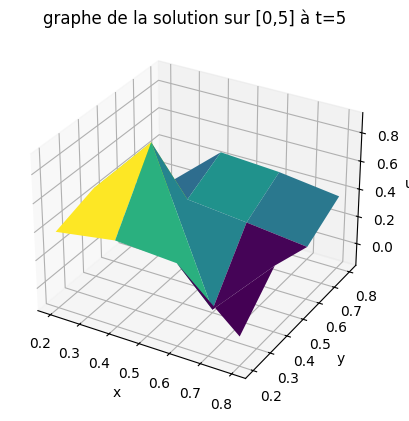

In [112]:
#Cette cellule sert à tracer le graphe de la solution sur [0,5] à t = 5

u_f2 = u1[53]
Nx = Ny = u_f2.shape[0]
dx = 1/(Nx+1)
X = np.linspace(dx, 1-dx, Nx)
Y = np.linspace(dx, 1-dx, Nx)
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, u_f2, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u_f')
ax.set_title('graphe de la solution sur [0,5] à t=5')
plt.show()

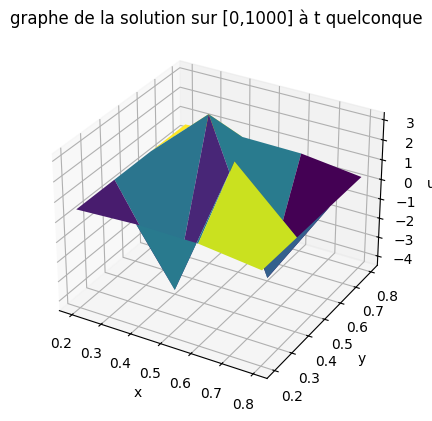

In [113]:
#Cette cellule sert à tracer le graphe de la solution sur [0,1000] à un instant quelconque au milieu de l'intervalle

u_f2 = u4[5000]
Nx = Ny = u_f2.shape[0]
dx = 1/(Nx+1)
X = np.linspace(dx, 1-dx, Nx)
Y = np.linspace(dx, 1-dx, Nx)
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, u_f2, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u_f')
ax.set_title('graphe de la solution sur [0,1000] à t quelconque')
plt.show()

Ces résultats sont très insatisfaisants car ils contredisent l'étude théorique qui assurait que u resterait entre 0 et 1. On en conclut que le schéma numérique utilisé est certainement en réalité instable, et donc que la condition $\frac{D\Delta t}{\Delta x^2} \leq \frac{1}{2}$ n'est pas suffisante pour assurer la convergence du schéma.

Les résultats de la simulation sont décevants car les interpréter n'a pas de sens : ils sont a priori très faux. Cependant les schémas aux différences explicites ont souvent tendance à être instables, donc on pouvait s'attendre à cela.